<a href="https://colab.research.google.com/github/aliu-7/Molecular-Property-Prediction-and-Optimization/blob/main/4_4_4_Analyzing_and_Interpreting_Neural_Network_Outputs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Run 4.4.3's Code

In [ ]:
# Step 1: Install RDKit (if not already installed)
!pip install -q rdkit

# Step 2: Import required libraries
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Step 3: Load the dataset
url = "https://raw.githubusercontent.com/Data-Chemist-Handbook/Data-Chemist-Handbook.github.io/refs/heads/master/_pages/BBBP.csv"
data = pd.read_csv(url)

# Step 4: Define descriptor calculation function
def compute_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    return [
        Descriptors.MolWt(mol),
        Descriptors.MolLogP(mol),
        Descriptors.TPSA(mol),
        Descriptors.NumRotatableBonds(mol),
        Descriptors.NumHDonors(mol),
        Descriptors.NumHAcceptors(mol)
    ]

# Step 5: Apply descriptor calculation
descriptor_data = data['smiles'].apply(compute_descriptors)
descriptor_data = descriptor_data.dropna()  # Remove invalid entries
X = np.array(descriptor_data.tolist())
y = data.loc[descriptor_data.index, 'p_np'].values  # Use same indices to align labels

# Step 6: Scale descriptors and split data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 7: Define and compile neural network
model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Step 8: Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Step 9: Evaluate the model
y_pred = (model.predict(X_test) > 0.5).astype(int)
print(classification_report(y_test, y_pred))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 32.4 MB/s eta 0:00:00


[23:19:00] Explicit valence for atom # 1 N, 4, is greater than permitted
[23:19:00] WARNING: not removing hydrogen atom without neighbors
[23:19:00] Explicit valence for atom # 6 N, 4, is greater than permitted
[23:19:00] WARNING: not removing hydrogen atom without neighbors
[23:19:00] WARNING: not removing hydrogen atom without neighbors
[23:19:00] WARNING: not removing hydrogen atom without neighbors
[23:19:00] WARNING: not removing hydrogen atom without neighbors
[23:19:00] WARNING: not removing hydrogen atom without neighbors
[23:19:00] WARNING: not removing hydrogen atom without neighbors
[23:19:01] Explicit valence for atom # 6 N, 4, is greater than permitted
[23:19:01] WARNING: not removing hydrogen atom without neighbors
[23:19:01] WARNING: not removing hydrogen atom without neighbors
[23:19:01] WARNING: not removing hydrogen atom without neighbors
[23:19:01] WARNING: not removing hydrogen atom without neighbors
[23:19:01] Explicit valence for atom # 11 N, 4, is greater than pe

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7064 - loss: 0.6379 - val_accuracy: 0.8135 - val_loss: 0.4664
Epoch 2/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7943 - loss: 0.4868 - val_accuracy: 0.8440 - val_loss: 0.3677
Epoch 3/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8307 - loss: 0.4200 - val_accuracy: 0.8593 - val_loss: 0.3399
Epoch 4/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8287 - loss: 0.3963 - val_accuracy: 0.8746 - val_loss: 0.3324
Epoch 5/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8369 - loss: 0.4290 - val_accuracy: 0.8746 - val_loss: 0.3290
Epoch 6/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8580 - loss: 0.3925 - val_accuracy: 0.8777 - val_loss: 0.3268
Epoch 7/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8538 - loss: 0.3749 - val_accuracy: 0.8777 - val_loss: 0.3277
Epoch 8/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8475 - loss: 0.3900 - val_accuracy: 0.8746 - val_loss: 0.3259
Ep

# Feature Importance via Permutation

Although neural networks do not have built-in feature importance measures like decision trees, we can assess which molecular descriptors are influential using permutation importance. This involves:

1. Shuffling one feature’s values across the test set.
2. Measuring the drop in model performance.
3. Repeating this for each feature.

A larger drop implies that the feature was more important.


In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report

# Replace the Keras model with sklearn's MLP
mlp = MLPClassifier(hidden_layer_sizes=(32, 16), max_iter=500, random_state=42)
mlp.fit(X_train, y_train)

# Predict and evaluate
y_pred = mlp.predict(X_test)
print(classification_report(y_test, y_pred))

# Permutation importance
result = permutation_importance(mlp, X_test, y_test, n_repeats=10, random_state=42)

# Display feature importances
for i in result.importances_mean.argsort()[::-1]:
    print(f"Feature {i}: {result.importances_mean[i]:.4f}")

              precision    recall  f1-score   support

           0       0.75      0.58      0.65        99
           1       0.87      0.94      0.90       309

    accuracy                           0.85       408
   macro avg       0.81      0.76      0.78       408
weighted avg       0.84      0.85      0.84       408

Feature 1: 0.1010
Feature 2: 0.0904
Feature 0: 0.0897
Feature 5: 0.0551
Feature 4: 0.0466
Feature 3: 0.0301


# SHAP Values for Local Interpretability

SHAP (SHapley Additive exPlanations) is a powerful tool to understand how each input feature contributes to a single prediction. This is useful for inspecting outliers or understanding why two similar molecules receive different scores.

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
38/38 

PermutationExplainer explainer:  20%|██        | 2/10 [00:00<?, ?it/s]

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
39/

PermutationExplainer explainer:  40%|████      | 4/10 [00:22<00:21,  3.58s/it]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
37/37 ━━━

PermutationExplainer explainer:  50%|█████     | 5/10 [00:30<00:27,  5.48s/it]

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
40/40 ━━━━━

PermutationExplainer explainer:  60%|██████    | 6/10 [00:39<00:26,  6.63s/it]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
38

PermutationExplainer explainer:  70%|███████   | 7/10 [00:46<00:20,  6.91s/it]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
37/37 ━━━━━

PermutationExplainer explainer:  80%|████████  | 8/10 [00:55<00:14,  7.42s/it]

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
41/41 ━

PermutationExplainer explainer:  90%|█████████ | 9/10 [01:04<00:08,  8.00s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
36/36 ━━━━━━━━

PermutationExplainer explainer: 100%|██████████| 10/10 [01:12<00:00,  8.02s/it]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
38/38 ━━━━━━━

PermutationExplainer explainer: 11it [01:21,  9.03s/it]


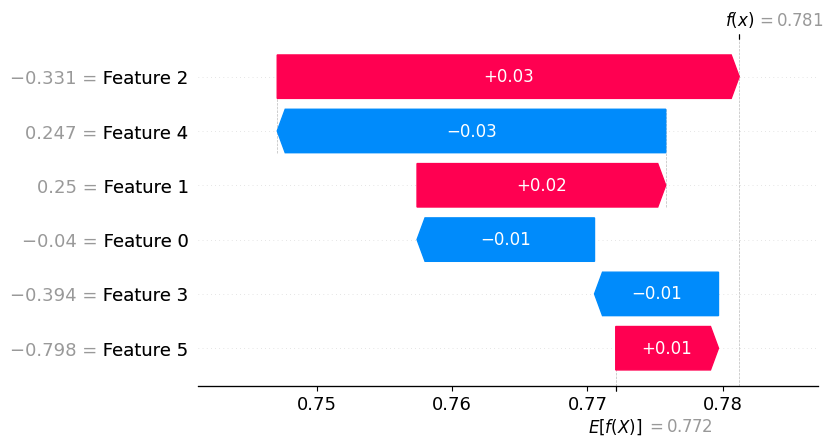

In [ ]:
import shap

explainer = shap.Explainer(model.predict, X_train[:100], algorithm="permutation")
shap_values = explainer(X_test[:10]) # subset to speed up the example

# Visualize for one example molecule
shap.plots.waterfall(shap_values[0])

# Visualizing Predictions vs. Actuals

For regression tasks (e.g., predicting solubility or LogP), a scatter plot of predicted vs. actual values is useful:

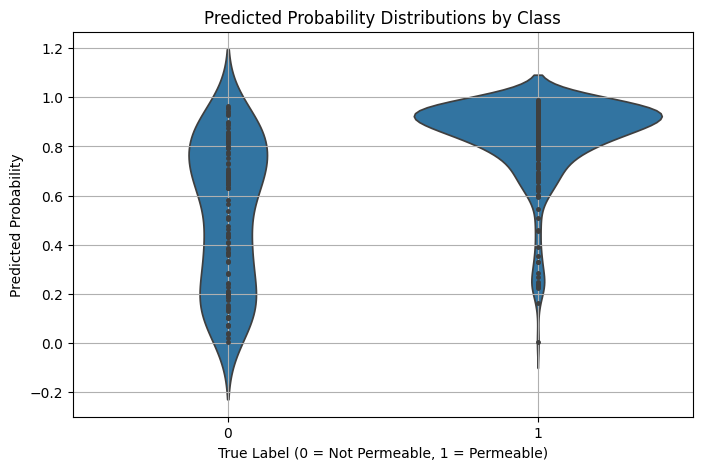

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ensure predictions are 1D array
probs = predictions.flatten()

# Create a DataFrame for easy plotting
import pandas as pd
df_plot = pd.DataFrame({
    'True Label': y_test,
    'Predicted Probability': probs
})

# Plot the distribution of predicted probabilities for each class
plt.figure(figsize=(8, 5))
sns.violinplot(x='True Label', y='Predicted Probability', data=df_plot, inner='point')
plt.title('Predicted Probability Distributions by Class')
plt.xlabel('True Label (0 = Not Permeable, 1 = Permeable)')
plt.ylabel('Predicted Probability')
plt.grid(True)
plt.show()